In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer

from utils import *

In [2]:
data = pd.read_csv('train.csv', index_col='id')

data['keyword'] = data.keyword.apply(lambda x: str(x))
data['location'] = data.location.apply(lambda x: str(x))

X_train, X_validation, y_train, y_validation = train_test_split(
    data.drop('target', axis=1), data.target, test_size=0.2
)

In [3]:
def get_ordinal_encoding(x):
    ordinal_encoding = np.argmax(x, axis=1)
    return ordinal_encoding


def make_categorical_numeric_encoder(feature):
    categorical_numeric_encoder_ct = Pipeline(
        [
            ('t_{}_hash'.format(feature), ColumnTransformer([('t_{}'.format(feature), HashingVectorizer(), feature)])),
            ('t_{}_number'.format(feature), FunctionTransformer(get_ordinal_encoding))
        ]
    )
    return categorical_numeric_encoder_ct

In [4]:
meta_data_encoder = ColumnTransformer(
    [
        ('mean_word_len', FunctionTransformer(lambda x: mean_word_length(x)), 'text'),
        ('tweet_length_t', FunctionTransformer(lambda x: tweet_length(x)), 'text')
    ]
)


text_encoder = Pipeline(
    [
        ('word_tokenizer', ColumnTransformer([('words', FunctionTransformer(get_words), 'text')])),
        ('stop_words_remover', FunctionTransformer(remove_stop_words)),
        ('cleaned_strings', FunctionTransformer(replace_numbers_and_punctuation)),
        ('count_vectorizer', CountVectorizer(ngram_range=(1, 1))),
        ('tfidf', TfidfTransformer(use_idf=True)),
    ]
)

keyword_encoder = make_categorical_numeric_encoder('keyword')
location_encoder = make_categorical_numeric_encoder('keyword')


In [5]:
feature_union_encoder = FeatureUnion(
    [
        ('meta_data_encoded', meta_data_encoder),
        ('text_encoded', text_encoder),
        ('keyword_encoded', keyword_encoder),
        ('location_encoded', location_encoder)
    ]
)

In [6]:
pipeline = Pipeline([
    ('encode_data', feature_union_encoder),
    ('classifier', RandomForestClassifier())
])
pipeline.fit(X_train, y_train)
accuracy_score(pipeline.predict(X_validation), y_validation)

0.7898883782009193

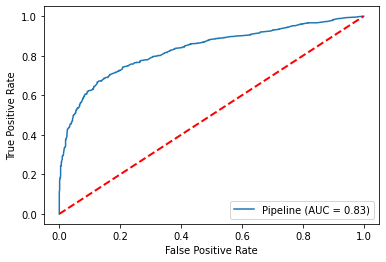

In [7]:
plot_roc_curve(pipeline, X_validation, y_validation)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.show()